In [434]:
import pandas as pd
import numpy as np

In [435]:
import multiprocessing

NUM_CPU = multiprocessing.cpu_count()
NUM_CPU

8

# Loading, processing, and splitting data

In [436]:
df = pd.read_csv('data/dataset.csv', index_col=False).sample(frac=1).reset_index(drop=True)
len(df)

6887

Let's also create a dataset where only features with >= 0.4 correlation with yield are kept.

In [437]:
df_corr = abs(df.corr(numeric_only=True)).sort_values(by='yield', ascending=False)[['yield']]
df_select_features = df[df_corr[df_corr['yield'] >= 0.4].index.tolist()]
df_select_features.loc[:, 'year'] = df['year'].copy()
df_select_features.columns

/var/folders/d9/kflmfc_149b3gpr245hj87gh0000gn/T/ipykernel_2307/3980492002.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Index(['yield', 'sample_val_July', 'sample_val_August', 'max_val_August',
       'max_val_July', 'sample_count_October', 'sample_count_June',
       'sample_count_April', 'sample_count_August', 'sample_count_July',
       'sample_count_September', 'max_val_September', 'sample_count_May',
       'sample_count_November', 'max_val_June', 'year'],
      dtype='object')

In [438]:
train_indices = df.index[df['year'] != 2021].to_list()
test_indices = df.index[df['year'] == 2021].to_list()

df.drop(columns=["year", "state", "county_name"], inplace=True)

In [439]:
print('Num training examples:', len(train_indices))
print('Num testing examples:', len(test_indices))

Num training examples: 6185
Num testing examples: 702


In [480]:
# Split our data into a training and test set
train_df = df.loc[train_indices]
test_df = df.loc[test_indices]

train_x, train_y = train_df.loc[:, train_df.columns != 'yield'].to_numpy(), train_df['yield'].to_numpy()
test_x, test_y = test_df.loc[:, test_df.columns != 'yield'].to_numpy(), test_df['yield'].to_numpy()

In [441]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [442]:
scale = StandardScaler()
scaled_train_x = scale.fit_transform(train_x)
scaled_test_x = scale.fit_transform(test_x)

In [443]:
def print_r_squared(pipe, train_x, train_y, test_x, test_y):

    print(f"Train R^2: {pipe.score(train_x, train_y)}")
    print(f"Test R^2: {pipe.score(test_x, test_y)}")


## LASSO

In [444]:
lasso_pipe = make_pipeline(
        StandardScaler(), 
        linear_model.LassoCV(cv=len(train_x), max_iter=10000, n_jobs=-1)
    )

lasso_pipe.fit(train_x, train_y)

/opt/homebrew/Caskroom/miniforge/base/envs/DA_F22/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.483e+00, tolerance: 3.905e-01



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv', LassoCV(cv=6185, max_iter=10000, n_jobs=-1))])

In [445]:
print_r_squared(lasso_pipe, train_x, train_y, test_x, test_y)
print(f"Lasso Alpha: {lasso_pipe.named_steps['lassocv'].alpha_}")

Train R^2: 0.3896473005056025
Test R^2: 0.34635434905252027
Lasso Alpha: 0.00039147055199904


Now that we have a good grasp of how to perform CV and create pipelines, lets
test all the models we wish to, i.e. Lasso/Ridge regression, random forest, KNN, and LSTM NN.

## Ridge Regression

In [446]:
ridge_pipe = make_pipeline(
    StandardScaler(),
    linear_model.RidgeCV(store_cv_values=True) #LOCV by default
)

ridge_pipe.fit(train_x, train_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv', RidgeCV(store_cv_values=True))])

In [447]:
mean_squared_error(ridge_pipe[1].predict(StandardScaler().fit_transform(train_x)), train_y, squared=False)

0.6183281538620261

In [448]:
ridge_pipe[1].cv_values_

array([[1.34892141e+00, 1.38746698e+00, 1.42050244e+00],
       [5.74509007e-04, 8.34846172e-05, 1.81999175e-03],
       [6.54749799e-01, 6.47413731e-01, 6.39265911e-01],
       ...,
       [9.25631246e-04, 5.13218273e-04, 1.08155207e-04],
       [2.04386009e+00, 2.10541455e+00, 2.24321327e+00],
       [2.10388984e-02, 1.23978480e-02, 4.94713728e-03]])

In [449]:
print_r_squared(ridge_pipe, train_x, train_y, test_x, test_y)
print(f"Ridge Alpha: {ridge_pipe.named_steps['ridgecv'].alpha_}")

Train R^2: 0.39450032935075996
Test R^2: 0.2915176602238625
Ridge Alpha: 0.1


## Random Forest

In [450]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [451]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [452]:
random_param_grid = {
    'bootstrap': [True, False],
    'n_estimators': [int(i) for i in np.linspace(200, 2000, 10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(i) for i in np.linspace(10, 110, 11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [453]:
# Random sampling to hone in on the range of values we want to perform Grid Search on

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_param_grid,
    n_iter=200,
    cv=5,
    n_jobs=-1
)

scaled_train_x = StandardScaler().fit_transform(train_x)
rf_random.fit(scaled_train_x, train_y)

/opt/homebrew/Caskroom/miniforge/base/envs/DA_F22/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/DA_F22/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/DA_F22/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, 

KeyboardInterrupt: 

In [456]:
baseline = RandomForestRegressor()
baseline.fit(scaled_train_x, train_y)
print("Baseline Performance:")
print_r_squared(baseline, scaled_train_x, train_y, StandardScaler().fit_transform(test_x), test_y)
print("Random Model Performance:")
print_r_squared(rf_random, scaled_train_x, train_y, StandardScaler().fit_transform(test_x), test_y)

RandomForestRegressor()

In [454]:
rf_random.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [455]:
# Perform gridsearch

param_grid = {
    'bootstrap': [True],
    'max_depth': [60, 70, 80, 90],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

rf_grid.fit(scaled_train_x, train_y)


/opt/homebrew/Caskroom/miniforge/base/envs/DA_F22/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/DA_F22/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/DA_F22/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, 

KeyboardInterrupt: 

In [ ]:
baseline = RandomForestRegressor()
baseline.fit(scaled_train_x, train_y)
print("Baseline Performance:")
print_r_squared(baseline, scaled_train_x, train_y, StandardScaler().fit_transform(test_x), test_y)
print("Tuned Model Performance:")
print_r_squared(rf_grid, scaled_train_x, train_y, StandardScaler().fit_transform(test_x), test_y)

Baseline Performance:
Train R^2: 0.44036018893996387
Test R^2: 0.33145357095064576
Tuned Model Performance:
Train R^2: 0.4403834939713135
Test R^2: 0.2938355584086475


In [457]:
rf_pipe = make_pipeline(
    StandardScaler(),
    baseline
)
rf_pipe.fit(train_x, train_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [459]:
print_r_squared(rf_pipe, train_x, train_y, test_x, test_y)

Train R^2: 0.44037380345475163
Test R^2: 0.3174545261835918


## KNN Regression

In [460]:
from sklearn.neighbors import KNeighborsRegressor

In [461]:
param_grid = {
    'n_neighbors': [i for i in range(3, round(np.sqrt(len(train_x))), 2)],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto'],
    'metric': ['minkowski', 'euclidean', 'cityblock']
}

In [462]:
knn_tuned = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)


In [463]:
knn_pipe = make_pipeline(
    StandardScaler(),
    knn_tuned
)

knn_pipe.fit(train_x, train_y)
print_r_squared(knn_pipe, train_x, train_y, test_x, test_y)

Train R^2: 0.439797112292571
Test R^2: 0.27293757189531354


In [ ]:
knn_pipe.score()

In [464]:
knn_pipe[1].best_params_

{'algorithm': 'auto',
 'metric': 'cityblock',
 'n_neighbors': 77,
 'weights': 'distance'}

In [465]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

## MLP

In [466]:
import tensorflow as tf
import tensorflow_addons as tfa

In [481]:
mlp_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(len(train_x[0]), )),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1)
])

mlp_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, amsgrad=True),
    loss='mean_squared_error',
    metrics=[tfa.metrics.RSquare()]
)
history = mlp_model.fit(train_x, train_y, epochs=500, validation_split=0.2)

Epoch 1/500
155/155 [==============================] - 1s 3ms/step - loss: 14.4118 - r_square: -21.5983 - val_loss: 12.4195 - val_r_square: -19.4944
Epoch 2/500
155/155 [==============================] - 0s 2ms/step - loss: 8.0269 - r_square: -11.5861 - val_loss: 7.3802 - val_r_square: -11.1786
Epoch 3/500
155/155 [==============================] - 0s 2ms/step - loss: 3.1989 - r_square: -4.0159 - val_loss: 3.0637 - val_r_square: -4.0556
Epoch 4/500
155/155 [==============================] - 0s 2ms/step - loss: 1.6389 - r_square: -1.5698 - val_loss: 1.3163 - val_r_square: -1.1721
Epoch 5/500
155/155 [==============================] - 0s 2ms/step - loss: 1.3251 - r_square: -1.0778 - val_loss: 0.8757 - val_r_square: -0.4450
Epoch 6/500
155/155 [==============================] - 0s 2ms/step - loss: 1.1882 - r_square: -0.8631 - val_loss: 0.7263 - val_r_square: -0.1985
Epoch 7/500
155/155 [==============================] - 0s 2ms/step - loss: 1.1028 - r_square: -0.7292 - val_loss: 0.6482 - v

In [479]:
print("Training Set:")
train_loss, train_r_square = mlp_model.evaluate(train_x, train_y)
print(f"loss: {train_loss:.3f}   r^2: {train_r_square:.3f}")

print("Testing Set:")
test_loss, test_r_square = mlp_model.evaluate(test_x, test_y)
print(f"loss: {train_loss:.3f}   r^2: {train_r_square:.3f}")


Training Set:
194/194 [==============================] - 0s 843us/step - loss: 0.3986 - r_square: 0.3687
loss: 0.399   r^2: 0.369
Testing Set:
22/22 [==============================] - 0s 876us/step - loss: 0.8855 - r_square: -0.0347
loss: 0.399   r^2: 0.369


In [ ]:
history.history.keys()

dict_keys(['loss', 'r_square', 'val_loss', 'val_r_square'])

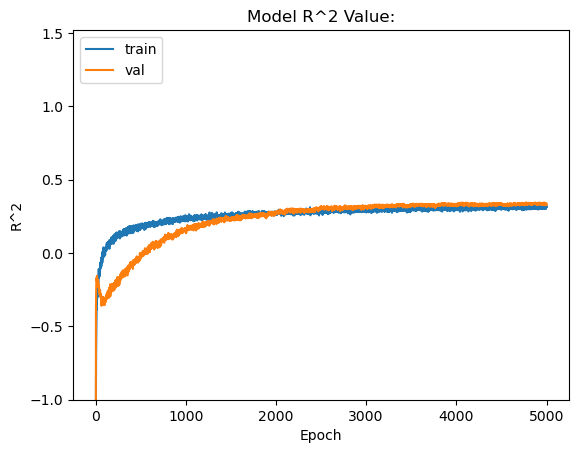

In [ ]:
plt.plot(history.history['r_square'])
plt.plot(history.history['val_r_square'])

plt.title('Model R^2 Value:')
plt.ylabel('R^2')
plt.ylim(-1)
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

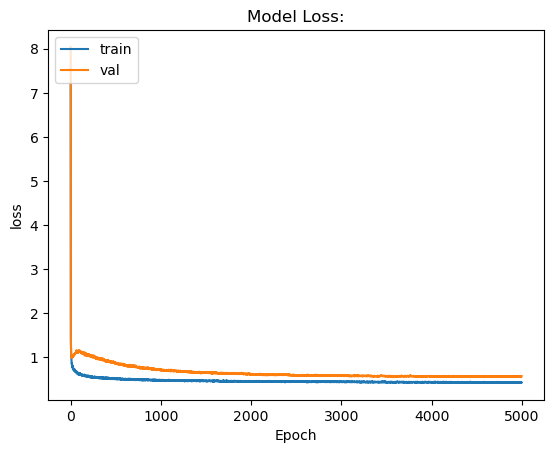

In [ ]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])

plt.title('Model Loss:')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# LSTM NN

Let's make sure we reshape our data properly - i.e. each sample is 8 rows long, with each row containing feature values for that particular month. 

In [ ]:
# Check shape of current dataset
train_x.shape

(6185, 48)

48 columns per year. That equates to 8 rows for one year and 6 features per row.

If the input into an LSTM model is of the form (num_samples, num_steps, num_features),
then our ultimate final data shape should be (6185, 8, 6).

In [ ]:
# Let's ensure that we transform our data properly first.
test_df = df.iloc[:5, 1:]
test_df

,sample_val_April,sample_val_May,sample_val_June,sample_val_July,sample_val_August,sample_val_September,sample_val_October,sample_val_November,sample_count_April,sample_count_May,...,max_val_October,max_val_November,precip_april,precip_may,precip_june,precip_july,precip_august,precip_september,precip_october,precip_november
0,0.251705,0.316802,0.462367,0.782174,0.844382,0.613009,0.339887,0.260029,1738452.0,2376580.0,...,0.432,0.282,163.784744,217.038086,112.705574,48.736252,39.590923,51.454273,81.460571,44.676483
1,0.327880,0.373086,0.405137,0.643940,0.742605,0.599170,0.370847,0.294307,117614.0,154702.0,...,0.438,0.345,125.299446,226.783554,157.673615,108.920052,146.320007,109.584343,135.842545,86.663437
2,0.261451,0.317732,0.662791,0.877068,0.856266,0.588368,0.322643,0.267157,1675488.0,1929587.0,...,0.452,0.307,133.558670,82.511307,178.725494,75.439461,135.609421,101.316078,103.076790,57.531929
3,0.252485,0.297611,0.524916,0.823821,0.835490,0.571272,0.337883,0.262973,1702391.0,2011378.0,...,0.412,0.297,67.716827,164.752197,119.391075,96.397095,71.994019,69.046417,31.123116,63.756676
4,0.295326,0.331953,0.491154,0.754203,0.739905,0.491530,0.313011,0.309462,460003.0,329438.0,...,0.386,0.325,144.227554,127.619690,73.840538,132.199097,120.017151,106.201843,39.292694,20.583719


In [ ]:
test_df = test_df.transpose()
test_df

,0,1,2,3,4
sample_val_April,2.517045e-01,0.327880,2.614511e-01,2.524846e-01,0.295326
sample_val_May,3.168024e-01,0.373086,3.177316e-01,2.976112e-01,0.331953
sample_val_June,4.623671e-01,0.405137,6.627912e-01,5.249159e-01,0.491154
sample_val_July,7.821737e-01,0.643940,8.770679e-01,8.238207e-01,0.754203
sample_val_August,8.443823e-01,0.742605,8.562662e-01,8.354903e-01,0.739905
sample_val_September,6.130089e-01,0.599170,5.883682e-01,5.712717e-01,0.491530
sample_val_October,3.398867e-01,0.370847,3.226428e-01,3.378830e-01,0.313011
sample_val_November,2.600287e-01,0.294307,2.671565e-01,2.629731e-01,0.309462
sample_count_April,1.738452e+06,117614.000000,1.675488e+06,1.702391e+06,460003.000000
sample_count_May,2.376580e+06,154702.000000,1.929587e+06,2.011378e+06,329438.000000


In [ ]:
restructured = np.array(np.vsplit(test_df.to_numpy(), 6)).transpose()
print(len(restructured), len(restructured[0]), len(restructured[0][0]))

5 8 6


It appears that we've successfully restructured our data for input into an LSTM model. Let's make sure this is the case

In [ ]:
print(pd.DataFrame(restructured[0]))

print("\n Test against first three months for this observation.")
for column in range(3):
    for val in test_df[0][column:-1:8]:
        print(val, end=" ")
    print()


          0          1         2      3      4           5
0  0.251705  1738452.0 -0.017962  0.224  0.318  163.784744
1  0.316802  2376580.0 -0.006948  0.257  0.405  217.038086
2  0.462367  2678998.0 -0.101633  0.337  0.821  112.705574
3  0.782174  2789683.0 -0.058326  0.670  0.891   48.736252
4  0.844382  2785648.0  0.001632  0.654  0.891   39.590923
5  0.613009  2831893.0  0.070759  0.297  0.824   51.454273
6  0.339887  1825013.0  0.028220  0.244  0.432   81.460571
7  0.260029  1762101.0  0.002362  0.228  0.282   44.676483
0.2517045216088796 1738452.0 -0.017962145057787 0.224 0.318 163.784744 
0.3168023718957493 2376580.0 -0.0069476281042506 0.257 0.405 217.038086 
0.4623670831407862 2678998.0 -0.1016329168592138 0.337 0.821 112.705574 


In [ ]:
print(pd.DataFrame(restructured[1]))

print("\n Test against first three months for this observation.")
for column in range(3):
    for val in test_df[1][column:-1:8]:
        print(val, end=" ")
    print()


          0         1         2      3      4           5
0  0.327880  117614.0 -0.007787  0.265  0.390  125.299446
1  0.373086  154702.0 -0.016414  0.292  0.505  226.783554
2  0.405137  168997.0 -0.195363  0.336  0.828  157.673615
3  0.643940  163413.0 -0.139560  0.567  0.881  108.920052
4  0.742605  167576.0 -0.021645  0.530  0.871  146.320007
5  0.599170  173876.0  0.072170  0.342  0.738  109.584343
6  0.370847  122559.0  0.025513  0.284  0.438  135.842545
7  0.294307  100981.0 -0.003360  0.248  0.345   86.663437

 Test against first three months for this observation.
0.3278795636573877 117614.0 -0.0077871030092789 0.265 0.39 125.299446 
0.3730858295303227 154702.0 -0.0164141704696772 0.292 0.505 226.783554 
0.4051365408853412 168997.0 -0.1953634591146587 0.336 0.828 157.673615 


In [ ]:
# check sample_val for all months
train_x[0][:-1:8]

array([ 2.51704522e-01,  1.73845200e+06, -1.79621451e-02,  2.24000000e-01,
        3.18000000e-01,  1.63784744e+02])

In [ ]:
# check sample_val column in restructured data
restructured[0][0]

array([ 2.51704522e-01,  1.73845200e+06, -1.79621451e-02,  2.24000000e-01,
        3.18000000e-01,  1.63784744e+02])

Awesome. The data seems to agree with one another. It's time to create the model!

In [ ]:
# Convert our training and testing data into the proper format
lstm_train = np.array(np.vsplit(train_x.transpose(), 6)).transpose()
lstm_test = np.array(np.vsplit(test_x.transpose(), 6)).transpose()
print(lstm_train.shape)
print(lstm_test.shape)

(6185, 8, 6)
(702, 8, 6)


In [ ]:
LSTM_model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(64, input_shape=(8, 6), activation='tanh', recurrent_dropout=0.4, return_sequences=True),
    tf.keras.layers.LSTM(64, activation='tanh', recurrent_dropout=0.4, return_sequences=True),
    tf.keras.layers.LSTM(64, activation='tanh', recurrent_dropout=0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

LSTM_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True),
    loss='mean_squared_error',
    metrics=[tfa.metrics.RSquare()]
)

history = LSTM_model.fit(lstm_train, train_y, epochs=100, validation_split=0.2)

Epoch 1/100
155/155 [==============================] - 12s 19ms/step - loss: 12.6018 - r_square: -19.0599 - val_loss: 1.1516 - val_r_square: -0.7875
Epoch 2/100
155/155 [==============================] - 2s 14ms/step - loss: 0.9554 - r_square: -0.5209 - val_loss: 0.6262 - val_r_square: 0.0280
Epoch 3/100
155/155 [==============================] - 4s 25ms/step - loss: 0.6519 - r_square: -0.0376 - val_loss: 0.4807 - val_r_square: 0.2539
Epoch 4/100
155/155 [==============================] - 3s 17ms/step - loss: 0.6068 - r_square: 0.0341 - val_loss: 0.4320 - val_r_square: 0.3295
Epoch 5/100
155/155 [==============================] - 2s 13ms/step - loss: 0.5786 - r_square: 0.0790 - val_loss: 0.4279 - val_r_square: 0.3359
Epoch 6/100
155/155 [==============================] - 2s 15ms/step - loss: 0.5650 - r_square: 0.1006 - val_loss: 0.4177 - val_r_square: 0.3516
Epoch 7/100
155/155 [==============================] - 2s 16ms/step - loss: 0.5661 - r_square: 0.0989 - val_loss: 0.4158 - val_r_

In [475]:
print("Model Evaluation: ")

print("Training Set:")
loss, r_square = LSTM_model.evaluate(lstm_train, train_y)
print(f"loss: {loss:.3f}   r^2: {r_square:.3f}")

print("Test Set:")
loss, r_square = LSTM_model.evaluate(lstm_test, test_y)
print(f"loss: {loss:.3f}   r^2: {r_square:.3f}")

Model Evaluation: 
Training Set:
194/194 [==============================] - 1s 3ms/step - loss: 0.8671 - r_square: -0.3733
loss: 0.867   r^2: -0.373
Test Set:
22/22 [==============================] - 0s 8ms/step - loss: 1.0725 - r_square: -0.2532
loss: 1.073   r^2: -0.253


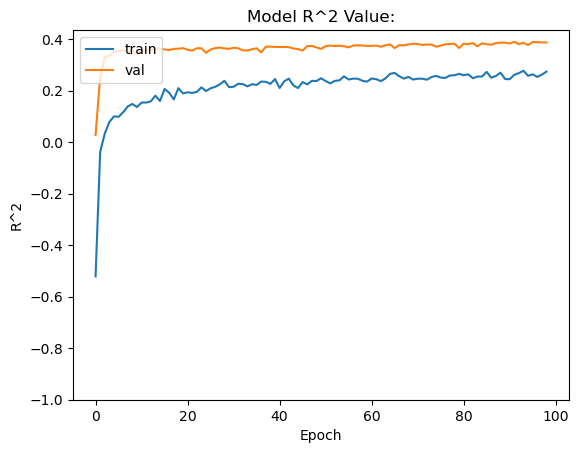

In [ ]:
plt.plot(history.history['r_square'][1:])
plt.plot(history.history['val_r_square'][1:])

plt.title('Model R^2 Value:')
plt.ylabel('R^2')
plt.xlabel('Epoch')
plt.ylim(bottom=-1)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

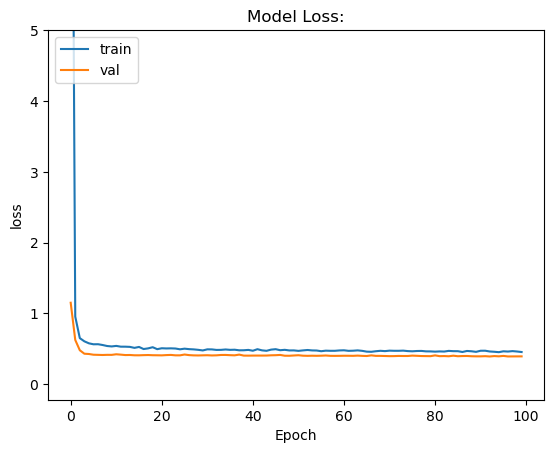

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss:')
plt.ylabel('loss')
plt.ylim(top=5)
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()